In [0]:
import tensorflow as tf
from tensorflow.keras import layers
from PIL import Image
import os
import pathlib
import numpy as np
import pathlib
import shutil

In [0]:
BASE_PATH = '/dbfs/FileStore/shared_uploads/wu.wenjun@otis.com/0331'
DATA_PATH = '/dbfs/FileStore/shared_uploads/wu.wenjun@otis.com/Pictures'

checkpoint_path = BASE_PATH + "/Model/Best_Model_Small.h5py"
checkpoint_dir = os.path.dirname(checkpoint_path)
# train_dir = pathlib.Path(DATA_PATH+'/training')
# val_dir = pathlib.Path(DATA_PATH+'/val')

# train_dir = dbutils.fs.ls(DATA_PATH+"/train/")
# val_dir = dbutils.fs.ls(DATA_PATH+"/val/")
batch_size = 128
img_height = 120
img_width = 160

resized_height = 120
resized_width = 160

# IMG_SHAPE = (224, 224, 3)
# CLASS_PEOPLE = "/dbfs/FileStore/shared_uploads/wu.wenjun@otis.com/training/people_class"
num_classes = 2
NUM_EPOCHS = 400
seed = 12
log_dir = BASE_PATH + "/logs"

STEPS_PER_EPOCH = 1508 //batch_size

In [0]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
data_augmentation = tf.keras.Sequential([
#   layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomFlip("horizontal"),
  layers.experimental.preprocessing.RandomRotation(0.2),
  layers.experimental.preprocessing.RandomZoom(0.2),
  layers.experimental.preprocessing.RandomContrast(0.2),
#   layers.experimental.preprocessing.RandomContrast(0.2),
])

resize = tf.keras.layers.experimental.preprocessing.Resizing(resized_height, resized_width)

def preprocess_input(image):
    return (image/127.5) - 1

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  DATA_PATH,
  seed=seed,
  shuffle=True,
  validation_split=0.2,
  subset='training',
  image_size=(img_height, img_width)
)
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)

train_ds = train_ds.map(
  lambda x, y: (data_augmentation(x, training=True), y))

train_ds = train_ds.map(
  lambda x, y: (preprocess_input(x), y))


val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  DATA_PATH,
  seed=seed,
  shuffle=True,
  validation_split=0.2,
  subset='validation',
  image_size=(img_height, img_width)
)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.map(
  lambda x, y: (preprocess_input(x), y))

Found 11163 files belonging to 2 classes.
Using 8931 files for training.
Found 11163 files belonging to 2 classes.
Using 2232 files for validation.

In [0]:
class CustomLearningRateScheduler(tf.keras.callbacks.Callback):
    """Learning rate scheduler which sets the learning rate according to schedule.

  Arguments:
      schedule: a function that takes an epoch index
          (integer, indexed from 0) and current learning rate
          as inputs and returns a new learning rate as output (float).
  """

    def __init__(self, schedule):
        super(CustomLearningRateScheduler, self).__init__()
        self.schedule = schedule

    def on_epoch_begin(self, epoch, logs=None):
        if not hasattr(self.model.optimizer, "lr"):
            raise ValueError('Optimizer must have a "lr" attribute.')
        # Get the current learning rate from model's optimizer.
        lr = float(tf.keras.backend.get_value(self.model.optimizer.learning_rate))
        # Call schedule function to get the scheduled learning rate.
        scheduled_lr = self.schedule(epoch, lr)
        # Set the value back to the optimizer before this epoch starts
        tf.keras.backend.set_value(self.model.optimizer.lr, scheduled_lr)
        print("\nEpoch %05d: Learning rate is %6.4f." % (epoch, scheduled_lr))


LR_SCHEDULE = [
    # (epoch to start, learning rate) tuples
    (10, 0.005),
    (30, 0.001),
    (50, 0.0005)
]


def lr_schedule(epoch, lr):
    """Helper function to retrieve the scheduled learning rate based on epoch."""
    if epoch < LR_SCHEDULE[0][0] or epoch > LR_SCHEDULE[-1][0]:
        return lr
    for i in range(len(LR_SCHEDULE)):
        if epoch == LR_SCHEDULE[i][0]:
            return LR_SCHEDULE[i][1]
    return lr

In [0]:
from tensorflow.keras.layers import Conv2D, DepthwiseConv2D, Dense, GlobalAveragePooling2D,Input
from tensorflow.keras.layers import Activation, BatchNormalization, Add, Multiply, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K

# 定义relu6激活函数
def relu6(x):
    return K.relu(x, max_value=6.0)
# 定义h-swish激活函数
def hard_swish(x):
    return x * K.relu(x + 3.0, max_value=6.0) / 6.0
# 定义返回的激活函数是relu6还是h-swish
def return_activation(x, nl):
    if nl == 'HS':
        x = Activation(hard_swish)(x)
    if nl == 'RE':
        x = Activation(relu6)(x)
    return x
# 定义卷积块(卷积+标准化+激活函数)
def conv_block(inputs, filters, kernel, strides, nl):
    channel_axis = 1 if K.image_data_format() == 'channels_first' else -1
    x = Conv2D(filters, kernel, padding='same', strides=strides)(inputs)
    x = BatchNormalization(axis=channel_axis)(x)
    return return_activation(x, nl)
# 定义注意力机制模块
def SE(inputs):
    input_channels = int(inputs.shape[-1])
    x = GlobalAveragePooling2D()(inputs)
    x = Dense(input_channels, activation='relu')(x)
    x = Dense(input_channels, activation='hard_sigmoid')(x)
    x = Reshape((1, 1, input_channels))(x)
    x = Multiply()([inputs, x])
    return x

def bottleneck(inputs, filters, kernel, e, s, squeeze, nl,alpha=1.0):
    channel_axis = 1 if K.image_data_format() == 'channels_first' else -1
    input_shape = K.int_shape(inputs)
    tchannel = int(e)
    cchannel = int(alpha * filters)
    r = s == 1 and input_shape[3] == filters
    x = conv_block(inputs, tchannel, (1,1), (1,1), nl)
    x = DepthwiseConv2D(kernel, strides=(s,s), depth_multiplier=1, padding='same')(x)
    x = BatchNormalization(axis=channel_axis)(x)
    x = return_activation(x,nl)
    if squeeze:
        x = SE(x)
    x = Conv2D(cchannel, (1,1), strides=(1,1), padding='same')(x)
    x = BatchNormalization(axis=channel_axis)(x)
    if r:
        x = Add()([x, inputs])
    return x


def MobileNetv3_small(shape = (224,224,3),n_class = 1000,alpha=1.0):
    inputs = Input(shape)
    x = conv_block(inputs, 16, (3, 3), strides=(2, 2), nl='HS')
    x = bottleneck(x, 16, (3, 3), e=16, s=2, squeeze=True, nl='RE', alpha=alpha)
    x = bottleneck(x, 24, (3, 3), e=72, s=2, squeeze=False, nl='RE', alpha=alpha)
    x = bottleneck(x, 24, (3, 3), e=88, s=1, squeeze=False, nl='RE', alpha=alpha)
    x = bottleneck(x, 40, (5, 5), e=96, s=2, squeeze=True, nl='HS', alpha=alpha)
    x = bottleneck(x, 40, (5, 5), e=240, s=1, squeeze=True, nl='HS', alpha=alpha)
    x = bottleneck(x, 40, (5, 5), e=240, s=1, squeeze=True, nl='HS', alpha=alpha)
    x = bottleneck(x, 48, (5, 5), e=120, s=1, squeeze=True, nl='HS', alpha=alpha)
    x = bottleneck(x, 48, (5, 5), e=144, s=1, squeeze=True, nl='HS', alpha=alpha)
    x = bottleneck(x, 96, (5, 5), e=288, s=2, squeeze=True, nl='HS', alpha=alpha)
    x = bottleneck(x, 96, (5, 5), e=576, s=1, squeeze=True, nl='HS', alpha=alpha)
    x = bottleneck(x, 96, (5, 5), e=576, s=1, squeeze=True, nl='HS', alpha=alpha)

      
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, x)

    return model

model = MobileNetv3_small(shape = (img_height, img_width, 3))
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type) Output Shape Param # Connected to 
==================================================================================================
input_1 (InputLayer) [(None, 120, 160, 3) 0 
__________________________________________________________________________________________________
conv2d (Conv2D) (None, 60, 80, 16) 448 input_1[0][0] 
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 60, 80, 16) 64 conv2d[0][0] 
__________________________________________________________________________________________________
activation (Activation) (None, 60, 80, 16) 0 batch_normalization[0][0] 
__________________________________________________________________________________________________
conv2d_1 (Conv2D) (None, 60, 80, 16) 272 activation[0][0] 
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 60, 80, 16) 64 conv2d_1[0][0] 
__________________________________________________________________________________________________
activation_1 (Activation) (None, 60, 80, 16) 0 batch_normalization_1[0][0] 
__________________________________________________________________________________________________
depthwise_conv2d (DepthwiseConv (None, 30, 40, 16) 160 activation_1[0][0] 
__________________________________________________________________________________________________
batch_normalization_2 (BatchNor (None, 30, 40, 16) 64 depthwise_conv2d[0][0] 
__________________________________________________________________________________________________
activation_2 (Activation) (None, 30, 40, 16) 0 batch_normalization_2[0][0] 
__________________________________________________________________________________________________
global_average_pooling2d (Globa (None, 16) 0 activation_2[0][0] 
__________________________________________________________________________________________________
dense (Dense) (None, 16) 272 global_average_pooling2d[0][0] 
__________________________________________________________________________________________________
dense_1 (Dense) (None, 16) 272 dense[0][0] 
__________________________________________________________________________________________________
reshape (Reshape) (None, 1, 1, 16) 0 dense_1[0][0] 
__________________________________________________________________________________________________
multiply (Multiply) (None, 30, 40, 16) 0 activation_2[0][0] 
 reshape[0][0] 
__________________________________________________________________________________________________
conv2d_2 (Conv2D) (None, 30, 40, 16) 272 multiply[0][0] 
__________________________________________________________________________________________________
batch_normalization_3 (BatchNor (None, 30, 40, 16) 64 conv2d_2[0][0] 
__________________________________________________________________________________________________
conv2d_3 (Conv2D) (None, 30, 40, 72) 1224 batch_normalization_3[0][0] 
__________________________________________________________________________________________________
batch_normalization_4 (BatchNor (None, 30, 40, 72) 288 conv2d_3[0][0] 
__________________________________________________________________________________________________
activation_3 (Activation) (None, 30, 40, 72) 0 batch_normalization_4[0][0] 
__________________________________________________________________________________________________
depthwise_conv2d_1 (DepthwiseCo (None, 15, 20, 72) 720 activation_3[0][0] 
__________________________________________________________________________________________________
batch_normalization_5 (BatchNor (None, 15, 20, 72) 288 depthwise_conv2d_1[0][0] 
__________________________________________________________________________________________________
activation_4 (Activation) (None, 15, 20, 72) 0 batch_normalization_5[0][0] 
____________

In [0]:
def get_compiled_model(alpha=1.0, lr=0.001):
    model = MobileNetv3_small(shape = (img_height, img_width, 3))
    
    model.compile(
                optimizer=tf.keras.optimizers.SGD(learning_rate=lr, momentum=0.9),
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])
    return model

In [0]:
def train_and_evaluate(train_ds, val_ds=None, lr=0.001):
    model = get_compiled_model()
#     model = get_compiled_model_2()

    
#     model.save_weights(checkpoint_path.format(epoch=0))

    # 创建一个保存模型权重的回调
    cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                     save_weights_only= False,
                                                     save_best_only = True,
                                                     monitor='accuracy',
                                                     mode='auto', 
                                                     save_freq='epoch',
                                                     verbose=1)
    early_stop = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=10)
    board_callback = tf.keras.callbacks.TensorBoard(
        log_dir=log_dir,
        histogram_freq=0,  # How often to log histogram visualizations
        embeddings_freq=0,  # How often to log embedding visualizations
        update_freq="epoch",
    )  # How often to write logs (default: once per epoch)
    
#     steps_per_epoch = len(train_ds) // batch_size
    hist = model.fit(train_ds, 
#                      steps_per_epoch=steps_per_epoch,
                     epochs=NUM_EPOCHS,
                     validation_data=val_ds,
#                      class_weight={0:0.3, 1:0.7},
#                      validation_steps=validation_steps,
                     verbose=2,
                     callbacks=[
                       cp_callback, 
#                        board_callback, 
                       early_stop,
#                        CustomLearningRateScheduler(lr_schedule),
                     ])
#     model.save('saved_model/my_model')
    return hist,model

In [0]:
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
if gpus:
  # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
  try:
    for gpu in gpus:
#       tf.config.experimental.set_memory_growth(gpu, True)
      print('yes')
#     tf.config.experimental.set_virtual_device_configuration(
#         gpus[0],
#         [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024)])
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
yes
yes
2 Physical GPUs, 2 Logical GPUs

In [0]:
tf.debugging.set_log_device_placement(True)
strategy = tf.distribute.MirroredStrategy()
with strategy.scope():
  hist,model = train_and_evaluate(train_ds,val_ds)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
Epoch 1/400
INFO:tensorflow:batch_all_reduce: 174 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 174 all-reduces with algorithm = nccl, num_packs = 1
280/280 - 408s - loss: 0.7311 - accuracy: 0.5659 - val_loss: 0.7034 - val_accuracy: 0.4754

Epoch 00001: accuracy improved from -inf to 0.56589, saving model to /dbfs/FileStore/shared_uploads/wu.wenjun@otis.com/0331/Model/Best_Model_Small.h5py
INFO:tensorflow:Assets written to: /dbfs/FileStore/shared_uploads/wu.wenjun@otis.com/0331/Model/Best_Model_Small.h5py/assets
Epoch 2/400
280/280 - 41s - loss: 0.5971 - accuracy: 0.6792 - val_loss: 0.6396 - val_accuracy: 0.7065

Epoch 00002: accuracy improved from 0.56589 to 0.67921, saving model to /dbfs/FileStore/shared_uploads/wu.wenjun@otis.com/0331/Model/Best_Model_Small.h5py
INFO:tensorflow:Assets written to: /dbfs/FileStore/shared_uploads/wu.wenjun@otis.com/0331/Model/Best_Model_Small.h5py/assets
Epoch 3/400
280/280 - 41s - loss: 0.5227 - accuracy: 0.7440 - val_loss: 0.5002 - val_accuracy: 0.7558

Epoch 00003: accuracy improved from 0.67921 to 0.74404, saving model to /dbfs/FileStore/shared_uploads/wu.wenjun@otis.com/0331/Model/Best_Model_Small.h5py
INFO:tensorflow:Assets written to: /dbfs/FileStore/shared_uploads/wu.wenjun@otis.com/0331/Model/Best_Model_Small.h5py/assets
Epoch 4/400
280/280 - 41s - loss: 0.4674 - accuracy: 0.7766 - val_loss: 0.4035 - val_accuracy: 0.8203

Epoch 00004: accuracy improved from 0.74404 to 0.77662, saving model to /dbfs/FileStore/shared_uploads/wu.wenjun@otis.com/0331/Model/Best_Model_Small.h5py
INFO:tensorflow:Assets written to: /dbfs/FileStore/shared_uploads/wu.wenjun@otis.com/0331/Model/Best_Model_Small.h5py/assets
Epoch 5/400
280/280 - 41s - loss: 0.4140 - accuracy: 0.8133 - val_loss: 0.3962 - val_accuracy: 0.8244

Epoch 00005: accuracy improved from 0.77662 to 0.81335, saving model to /dbfs/FileStore/shared_uploads/wu.wenjun@otis.com/0331/Model/Best_Model_Small.h5py
INFO:tensorflow:Assets written to: /dbfs/FileStore/shared_uploads/wu.wenjun@otis.com/0331/Model/Best_Model_Small.h5py/assets
Epoch 6/400
280/280 - 41s - loss: 0.3862 - accuracy: 0.8322 - val_loss: 0.3240 - val_accuracy: 0.8634

Epoch 00006: accuracy improved from 0.81335 to 0.83216, saving model to /dbfs/FileStore/shared_uploads/wu.wenjun@otis.com/0331/Model/Best_Model_Small.h5py
INFO:tensorflow:Assets written to: /dbfs/FileStore/shared_uploads/wu.wenjun@otis.com/0331/Model/Best_Model

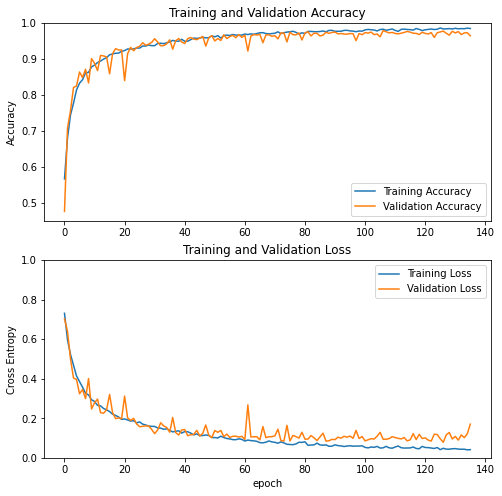

In [0]:
import matplotlib.pyplot as plt
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']

loss = hist.history['loss']
val_loss = hist.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [0]:
# !tar -cvf /dbfs/FileStore/shared_uploads/wu.wenjun@otis.com/0325/Model/Best_Model.tar /dbfs/FileStore/shared_uploads/wu.wenjun@otis.com/0325/Model/Best_Model